###EfficientNet. Another approch for BengaliAI competion.

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-03-17 10:57:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.59.23, 35.168.165.30, 52.3.79.57, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.59.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  13.3MB/s    in 1.0s    

2020-03-17 10:57:18 (13.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
import os
LOG_DIR = 'runs'
os.makedirs(LOG_DIR, exist_ok=True)
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://4baa776f.ngrok.io


In [0]:
#initialize writer for tenserboard
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter('./runs')


In [0]:
## Load Libraries 
import numpy as np 
import pandas as pd
import cv2
import gc
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm


## This library is for augmentations .
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma,
    ShiftScaleRotate    
) 

#### Data setup part 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
##Path for data 
PATH = '/content/gdrive/My Drive/datasets/bengali-feather/'


In [0]:
## Load Feather Data 
train = pd.read_csv(PATH + "train.csv")
data0 = pd.read_feather(PATH + 'train_data_0.feather')
data1 = pd.read_feather(PATH + 'train_data_1.feather')
data2 = pd.read_feather(PATH + 'train_data_2.feather')
data3 = pd.read_feather(PATH + 'train_data_3.feather')
data_full = pd.concat([data0,data1,data2,data3],ignore_index=True)
del data0,data1,data2,data3
gc.collect()
data_full.shape

(200840, 16385)

In [0]:
## Add Augmentations as suited from Albumentations library
train_aug = Compose([ 
    #HorizontalFlip(p=0.1),              
    #CenterCrop(p=0.5, height=100, width=100),
    #PadIfNeeded(min_height=128, min_width=128, p=1),
    ShiftScaleRotate(p=1),
    #OneOf([
    #    ElasticTransform(p=0.1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #    GridDistortion(distort_limit =0.1 , border_mode =0 ,p=0.1),
    #    OpticalDistortion(p=0.1, distort_limit= 0.1, shift_limit=0.2)                  
    #    ], p=0.1),
    RandomGamma(p=0.8)])


In [0]:
## Create dataset function
class GraphemeDataset(Dataset):
    def __init__(self,df,label,_type='train',transform =True,aug=train_aug):
        self.df = df
        self.label = label
        self.aug = aug
        self.transform = transform
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        label1 = self.label.vowel_diacritic.values[idx]
        label2 = self.label.grapheme_root.values[idx]
        label3 = self.label.consonant_diacritic.values[idx]
        #image = self.df.iloc[idx][1:].values.reshape(128,128).astype(np.float)
        image = self.data[idx, :].reshape(128,128).astype(np.float)
        if self.transform:
          augment = self.aug(image =image)
          image = augment['image']

        return image,label1,label2,label3

In [0]:
## Do a train-valid split of the data to create dataset and dataloader . Specify random seed to get reproducibility 
from sklearn.model_selection import train_test_split
train_df , valid_df = train_test_split(train,test_size=0.20, random_state=42,shuffle=True) ## Split Labels
data_train_df, data_valid_df = train_test_split(data_full,test_size=0.20, random_state=42,shuffle =True) ## split data
del data_full 
gc.collect()

0

In [0]:
##Creating the train and valid dataset for training . Training data has the transform flag ON
train_dataset = GraphemeDataset(data_train_df ,train_df,transform = True) 
valid_dataset = GraphemeDataset(data_valid_df ,valid_df,transform = False) 

In [0]:
##Visulization function for checking Original and augmented image
def visualize(original_image,aug_image):
    fontsize = 18
    
    f, ax = plt.subplots(1, 2, figsize=(8, 8))

    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original image', fontsize=fontsize)
    ax[1].imshow(aug_image,cmap='gray')
    ax[1].set_title('Augmented image', fontsize=fontsize)
    

In [0]:
## One image taken from raw dataframe another from dataset 
orig_image = data_train_df.iloc[0, 1:].values.reshape(128,128).astype(np.float)
aug_image = train_dataset[0][0]

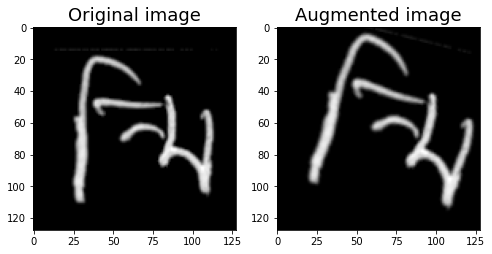

In [0]:
## Check it 
visualize (orig_image,aug_image)

In [0]:
## Create data loader and get ready for training .
batch_size = 32 
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)


#### Model creation part 

In [0]:
## Mish Activation Function Not yet Used . May be later 
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x

In [0]:
## Code copied from Lukemelas github repository have a look
## https://github.com/lukemelas/EfficientNet-PyTorch/tree/master/efficientnet_pytorch
"""
This file contains helper functions for building the model and for loading model parameters.
These helper functions are built to mirror those in the official TensorFlow implementation.
"""

import re
import math
import collections
from functools import partial
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

########################################################################
############### HELPERS FUNCTIONS FOR MODEL ARCHITECTURE ###############
########################################################################


# Parameters for the entire model (stem, all blocks, and head)
GlobalParams = collections.namedtuple('GlobalParams', [
    'batch_norm_momentum', 'batch_norm_epsilon', 'dropout_rate',
    'num_classes', 'width_coefficient', 'depth_coefficient',
    'depth_divisor', 'min_depth', 'drop_connect_rate', 'image_size'])

# Parameters for an individual model block
BlockArgs = collections.namedtuple('BlockArgs', [
    'kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'stride', 'se_ratio'])

# Change namedtuple defaults
GlobalParams.__new__.__defaults__ = (None,) * len(GlobalParams._fields)
BlockArgs.__new__.__defaults__ = (None,) * len(BlockArgs._fields)


class SwishImplementation(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * torch.sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = torch.sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))


class MemoryEfficientSwish(nn.Module):
    def forward(self, x):
        return SwishImplementation.apply(x)

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


def round_filters(filters, global_params):
    """ Calculate and round number of filters based on depth multiplier. """
    multiplier = global_params.width_coefficient
    if not multiplier:
        return filters
    divisor = global_params.depth_divisor
    min_depth = global_params.min_depth
    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    if new_filters < 0.9 * filters:  # prevent rounding by more than 10%
        new_filters += divisor
    return int(new_filters)


def round_repeats(repeats, global_params):
    """ Round number of filters based on depth multiplier. """
    multiplier = global_params.depth_coefficient
    if not multiplier:
        return repeats
    return int(math.ceil(multiplier * repeats))


def drop_connect(inputs, p, training):
    """ Drop connect. """
    if not training: return inputs
    batch_size = inputs.shape[0]
    keep_prob = 1 - p
    random_tensor = keep_prob
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype, device=inputs.device)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prob * binary_tensor
    return output


def get_same_padding_conv2d(image_size=None):
    """ Chooses static padding if you have specified an image size, and dynamic padding otherwise.
        Static padding is necessary for ONNX exporting of models. """
    if image_size is None:
        return Conv2dDynamicSamePadding
    else:
        return partial(Conv2dStaticSamePadding, image_size=image_size)


class Conv2dDynamicSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a dynamic image size """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class Conv2dStaticSamePadding(nn.Conv2d):
    """ 2D Convolutions like TensorFlow, for a fixed image size"""

    def __init__(self, in_channels, out_channels, kernel_size, image_size=None, **kwargs):
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)
        self.stride = self.stride if len(self.stride) == 2 else [self.stride[0]] * 2

        # Calculate padding based on image size and save it
        assert image_size is not None
        ih, iw = image_size if type(image_size) == list else [image_size, image_size]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            self.static_padding = nn.ZeroPad2d((pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2))
        else:
            self.static_padding = Identity()

    def forward(self, x):
        x = self.static_padding(x)
        x = F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
        return x


class Identity(nn.Module):
    def __init__(self, ):
        super(Identity, self).__init__()

    def forward(self, input):
        return input


########################################################################
############## HELPERS FUNCTIONS FOR LOADING MODEL PARAMS ##############
########################################################################


def efficientnet_params(model_name):
    """ Map EfficientNet model name to parameter coefficients. """
    params_dict = {
        # Coefficients:   width,depth,res,dropout
        'efficientnet-b0': (1.0, 1.0, 224, 0.2),
        'efficientnet-b1': (1.0, 1.1, 240, 0.2),
        'efficientnet-b2': (1.1, 1.2, 260, 0.3),
        'efficientnet-b3': (1.2, 1.4, 300, 0.3),
        'efficientnet-b4': (1.4, 1.8, 380, 0.4),
        'efficientnet-b5': (1.6, 2.2, 456, 0.4),
        'efficientnet-b6': (1.8, 2.6, 528, 0.5),
        'efficientnet-b7': (2.0, 3.1, 600, 0.5),
    }
    return params_dict[model_name]


class BlockDecoder(object):
    """ Block Decoder for readability, straight from the official TensorFlow repository """

    @staticmethod
    def _decode_block_string(block_string):
        """ Gets a block through a string notation of arguments. """
        assert isinstance(block_string, str)

        ops = block_string.split('_')
        options = {}
        for op in ops:
            splits = re.split(r'(\d.*)', op)
            if len(splits) >= 2:
                key, value = splits[:2]
                options[key] = value

        # Check stride
        assert (('s' in options and len(options['s']) == 1) or
                (len(options['s']) == 2 and options['s'][0] == options['s'][1]))

        return BlockArgs(
            kernel_size=int(options['k']),
            num_repeat=int(options['r']),
            input_filters=int(options['i']),
            output_filters=int(options['o']),
            expand_ratio=int(options['e']),
            id_skip=('noskip' not in block_string),
            se_ratio=float(options['se']) if 'se' in options else None,
            stride=[int(options['s'][0])])

    @staticmethod
    def _encode_block_string(block):
        """Encodes a block to a string."""
        args = [
            'r%d' % block.num_repeat,
            'k%d' % block.kernel_size,
            's%d%d' % (block.strides[0], block.strides[1]),
            'e%s' % block.expand_ratio,
            'i%d' % block.input_filters,
            'o%d' % block.output_filters
        ]
        if 0 < block.se_ratio <= 1:
            args.append('se%s' % block.se_ratio)
        if block.id_skip is False:
            args.append('noskip')
        return '_'.join(args)

    @staticmethod
    def decode(string_list):
        """
        Decodes a list of string notations to specify blocks inside the network.
        :param string_list: a list of strings, each string is a notation of block
        :return: a list of BlockArgs namedtuples of block args
        """
        assert isinstance(string_list, list)
        blocks_args = []
        for block_string in string_list:
            blocks_args.append(BlockDecoder._decode_block_string(block_string))
        return blocks_args

    @staticmethod
    def encode(blocks_args):
        """
        Encodes a list of BlockArgs to a list of strings.
        :param blocks_args: a list of BlockArgs namedtuples of block args
        :return: a list of strings, each string is a notation of block
        """
        block_strings = []
        for block in blocks_args:
            block_strings.append(BlockDecoder._encode_block_string(block))
        return block_strings


def efficientnet(width_coefficient=None, depth_coefficient=None, dropout_rate=0.2,
                 drop_connect_rate=0.2, image_size=None, num_classes=1000):
    """ Creates a efficientnet model. """

    blocks_args = [
        'r1_k3_s11_e1_i32_o16_se0.25', 'r2_k3_s22_e6_i16_o24_se0.25',
        'r2_k5_s22_e6_i24_o40_se0.25', 'r3_k3_s22_e6_i40_o80_se0.25',
        'r3_k5_s11_e6_i80_o112_se0.25', 'r4_k5_s22_e6_i112_o192_se0.25',
        'r1_k3_s11_e6_i192_o320_se0.25',
    ]
    blocks_args = BlockDecoder.decode(blocks_args)

    global_params = GlobalParams(
        batch_norm_momentum=0.99,
        batch_norm_epsilon=1e-3,
        dropout_rate=dropout_rate,
        drop_connect_rate=drop_connect_rate,
        # data_format='channels_last',  # removed, this is always true in PyTorch
        num_classes=num_classes,
        width_coefficient=width_coefficient,
        depth_coefficient=depth_coefficient,
        depth_divisor=8,
        min_depth=None,
        image_size=image_size,
    )

    return blocks_args, global_params


def get_model_params(model_name, override_params):
    """ Get the block args and global params for a given model """
    if model_name.startswith('efficientnet'):
        w, d, s, p = efficientnet_params(model_name)
        # note: all models have drop connect rate = 0.2
        blocks_args, global_params = efficientnet(
            width_coefficient=w, depth_coefficient=d, dropout_rate=p, image_size=s)
    else:
        raise NotImplementedError('model name is not pre-defined: %s' % model_name)
    if override_params:
        # ValueError will be raised here if override_params has fields not included in global_params.
        global_params = global_params._replace(**override_params)
    return blocks_args, global_params


url_map = {
    'efficientnet-b0': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b0-355c32eb.pth',
    'efficientnet-b1': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b1-f1951068.pth',
    'efficientnet-b2': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b2-8bb594d6.pth',
    'efficientnet-b3': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b3-5fb5a3c3.pth',
    'efficientnet-b4': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth',
    'efficientnet-b5': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b5-b6417697.pth',
    'efficientnet-b6': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b6-c76e70fd.pth',
    'efficientnet-b7': 'http://storage.googleapis.com/public-models/efficientnet/efficientnet-b7-dcc49843.pth',
}


def load_pretrained_weights(model, model_name, load_fc=False):
    """ Loads pretrained weights, and downloads if loading for the first time. """
    state_dict = model_zoo.load_url(url_map[model_name])
    if load_fc:
        model.load_state_dict(state_dict)
    else:
        state_dict.pop('_fc.weight')
        state_dict.pop('_fc.bias')
        res = model.load_state_dict(state_dict, strict=False)
        assert set(res.missing_keys) == set(['_fc.weight', '_fc.bias']), 'issue loading pretrained weights'
    print('Loaded pretrained weights for {}'.format(model_name))

In [0]:
import torch
from torch import nn
from torch.nn import functional as F


class MBConvBlock(nn.Module):
    """
    Mobile Inverted Residual Bottleneck Block
    Args:
        block_args (namedtuple): BlockArgs, see above
        global_params (namedtuple): GlobalParam, see above
    Attributes:
        has_se (bool): Whether the block contains a Squeeze and Excitation layer.
    """

    def __init__(self, block_args, global_params):
        super().__init__()
        self._block_args = block_args
        self._bn_mom = 1 - global_params.batch_norm_momentum
        self._bn_eps = global_params.batch_norm_epsilon
        self.has_se = (self._block_args.se_ratio is not None) and (0 < self._block_args.se_ratio <= 1)
        self.id_skip = block_args.id_skip  # skip connection and drop connect

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Expansion phase
        inp = self._block_args.input_filters  # number of input channels
        oup = self._block_args.input_filters * self._block_args.expand_ratio  # number of output channels
        if self._block_args.expand_ratio != 1:
            self._expand_conv = Conv2d(in_channels=inp, out_channels=oup, kernel_size=1, bias=False)
            self._bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Depthwise convolution phase
        k = self._block_args.kernel_size
        s = self._block_args.stride
        self._depthwise_conv = Conv2d(
            in_channels=oup, out_channels=oup, groups=oup,  # groups makes it depthwise
            kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)

        # Squeeze and Excitation layer, if desired
        if self.has_se:
            num_squeezed_channels = max(1, int(self._block_args.input_filters * self._block_args.se_ratio))
            self._se_reduce = Conv2d(in_channels=oup, out_channels=num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2d(in_channels=num_squeezed_channels, out_channels=oup, kernel_size=1)

        # Output phase
        final_oup = self._block_args.output_filters
        self._project_conv = Conv2d(in_channels=oup, out_channels=final_oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        self._swish = MemoryEfficientSwish()

    def forward(self, inputs, drop_connect_rate=None):
        """
        :param inputs: input tensor
        :param drop_connect_rate: drop connect rate (float, between 0 and 1)
        :return: output of block
        """

        # Expansion and Depthwise Convolution
        x = inputs
        if self._block_args.expand_ratio != 1:
            x = self._swish(self._bn0(self._expand_conv(inputs)))
        x = self._swish(self._bn1(self._depthwise_conv(x)))

        # Squeeze and Excitation
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_expand(self._swish(self._se_reduce(x_squeezed)))
            x = torch.sigmoid(x_squeezed) * x

        x = self._bn2(self._project_conv(x))

        # Skip connection and drop connect
        input_filters, output_filters = self._block_args.input_filters, self._block_args.output_filters
        if self.id_skip and self._block_args.stride == 1 and input_filters == output_filters:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs  # skip connection
        return x

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()


class EfficientNet(nn.Module):
    """
    An EfficientNet model. Most easily loaded with the .from_name or .from_pretrained methods
    Args:
        blocks_args (list): A list of BlockArgs to construct blocks
        global_params (namedtuple): A set of GlobalParams shared between blocks
    Example:
        model = EfficientNet.from_pretrained('efficientnet-b0')
    """

    def __init__(self, blocks_args=None, global_params=None):
        super().__init__()
        assert isinstance(blocks_args, list), 'blocks_args should be a list'
        assert len(blocks_args) > 0, 'block args must be greater than 0'
        self._global_params = global_params
        self._blocks_args = blocks_args

        # Get static or dynamic convolution depending on image size
        Conv2d = get_same_padding_conv2d(image_size=global_params.image_size)

        # Batch norm parameters
        bn_mom = 1 - self._global_params.batch_norm_momentum
        bn_eps = self._global_params.batch_norm_epsilon

        # Stem
        in_channels = 1  # rgb
        out_channels = round_filters(32, self._global_params)  # number of output channels
        self._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Build blocks
        self._blocks = nn.ModuleList([])
        for block_args in self._blocks_args:

            # Update block input and output filters based on depth multiplier.
            block_args = block_args._replace(
                input_filters=round_filters(block_args.input_filters, self._global_params),
                output_filters=round_filters(block_args.output_filters, self._global_params),
                num_repeat=round_repeats(block_args.num_repeat, self._global_params)
            )

            # The first block needs to take care of stride and filter size increase.
            self._blocks.append(MBConvBlock(block_args, self._global_params))
            if block_args.num_repeat > 1:
                block_args = block_args._replace(input_filters=block_args.output_filters, stride=1)
            for _ in range(block_args.num_repeat - 1):
                self._blocks.append(MBConvBlock(block_args, self._global_params))

        # Head
        in_channels = block_args.output_filters  # output of final block
        out_channels = round_filters(1280, self._global_params)
        self._conv_head = Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)

        # Final linear layer
        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(self._global_params.dropout_rate)
        self._fc = nn.Linear(out_channels, self._global_params.num_classes)
        # vowel_diacritic
        self.fc1 = nn.Linear(out_channels,11)
        # grapheme_root
        self.fc2 = nn.Linear(out_channels,168)
        # consonant_diacritic
        self.fc3 = nn.Linear(out_channels,7)
        self._swish = MemoryEfficientSwish()

    def set_swish(self, memory_efficient=True):
        """Sets swish function as memory efficient (for training) or standard (for export)"""
        self._swish = MemoryEfficientSwish() if memory_efficient else Swish()
        for block in self._blocks:
            block.set_swish(memory_efficient)


    def extract_features(self, inputs):
        """ Returns output of the final convolution layer """

        # Stem
        x = self._swish(self._bn0(self._conv_stem(inputs)))

        # Blocks
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            x = block(x, drop_connect_rate=drop_connect_rate)

        # Head
        x = self._swish(self._bn1(self._conv_head(x)))

        return x

    def forward(self, inputs):
        """ Calls extract_features to extract features, applies final linear layer, and returns logits. """
        bs = inputs.size(0)
        # Convolution layers
        x = self.extract_features(inputs)

        # Pooling and final linear layer
        x = self._avg_pooling(x)
        x = x.view(bs, -1)
        x = self._dropout(x)
       # x = self._fc(x)
        x1 = self.fc1(x)
        x2= self.fc2(x)
        x3 = self.fc3(x)
        return x1,x2,x3

    @classmethod
    def from_name(cls, model_name, override_params=None):
        cls._check_model_name_is_valid(model_name)
        blocks_args, global_params = get_model_params(model_name, override_params)
        return cls(blocks_args, global_params)

    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000, in_channels = 3):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))
        if in_channels != 3:
            Conv2d = get_same_padding_conv2d(image_size = model._global_params.image_size)
            out_channels = round_filters(32, model._global_params)
            model._conv_stem = Conv2d(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        return model
    
    @classmethod
    def from_pretrained(cls, model_name, num_classes=1000):
        model = cls.from_name(model_name, override_params={'num_classes': num_classes})
        load_pretrained_weights(model, model_name, load_fc=(num_classes == 1000))

        return model

    @classmethod
    def get_image_size(cls, model_name):
        cls._check_model_name_is_valid(model_name)
        _, _, res, _ = efficientnet_params(model_name)
        return res

    @classmethod
    def _check_model_name_is_valid(cls, model_name, also_need_pretrained_weights=False):
        """ Validates model name. None that pretrained weights are only available for
        the first four models (efficientnet-b{i} for i in 0,1,2,3) at the moment. """
        num_models = 4 if also_need_pretrained_weights else 8
        valid_models = ['efficientnet-b'+str(i) for i in range(num_models)]
        if model_name not in valid_models:
            raise ValueError('model_name should be one of: ' + ', '.join(valid_models))

In [0]:
## Make sure we are using the GPU . Get CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
## Now create the model. Since its greyscale , I have not yet used pretrained model . In Later version ,
##I will make the necessary modification to load pretrained weights for greyscale by summing up the weights over one axis or copying greyscale into three channels
model = EfficientNet.from_name('efficientnet-b0').to(device)

In [0]:
## A Small but useful test of the Model by using dummy input . .
x = torch.zeros((32,1, 64, 64))
with torch.no_grad():
    output1,output2,output3 =model(x.cuda())
print(output3.shape)

torch.Size([32, 7])


In [0]:
## This is a placeholder for finetunign or inference when you want to load a previously trained model
##and want to finetune or want to do just inference

#model.load_state_dict(torch.load('/content/drive/My Drive/beng/effnetb0_trial_stage1.pth')) 

In [0]:
#model = ResNet34().to(device)
optimizer =torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, 1e-5)
criterion = nn.CrossEntropyLoss()
batch_size=32

#### Training and validation part 

In [0]:
## This function for train
## We are going to train and track accuracy and then evaluate and track validation accuracy
def train():
  model.train()
  losses = []
  accs = []
  acc= 0.0
  total = 0.0
  running_loss = 0.0
  running_acc = 0.0
  for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader),total=len(train_loader)):
      inputs = inputs.to(device)
      labels1 = labels1.to(device)
      labels2 = labels2.to(device)
      labels3 = labels3.to(device)
      total += len(inputs)
      optimizer.zero_grad()
      outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
      loss1 = criterion(outputs1,labels1)
      loss2 = 2* criterion(outputs2,labels2)
      loss3 = criterion(outputs3,labels3)
      running_loss += loss1+loss2+loss3
      running_acc += (outputs1.argmax(1)==labels1).float().mean()
      running_acc += (outputs2.argmax(1)==labels2).float().mean()
      running_acc += (outputs3.argmax(1)==labels3).float().mean()
      (loss1+loss2+loss3).backward()
      optimizer.step()
      acc = running_acc/total
      #scheduler.step()
  losses.append(running_loss/len(train_loader))
  accs.append(running_acc/(len(train_loader)*3))
  print('acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
  print('loss : {:.4f}'.format(running_loss/len(train_loader)))
  torch.save(model.state_dict(), PATH + 'effnetb0_trial_stage1.pth') ## Saving model weights
  # ================================================================== #
  #                        Tensorboard Logging                         #
  # ================================================================== #

  # 1. Log scalar values (scalar summary)
  info = { 'train accuracy': running_acc/(len(train_loader)*3), 
            'train loss': running_loss/len(train_loader)}

  for tag, value in info.items():
    tb.add_scalar(tag, value, epoch)


def evaluate():
   model.eval()
   losses = []
   accs = []
   acc= 0.0
   total = 0.0
   running_loss = 0.0
   running_acc = 0.0
   with torch.no_grad():
     for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(valid_loader),total=len(valid_loader)):
        inputs = inputs.to(device)
        labels1 = labels1.to(device)
        labels2 = labels2.to(device)
        labels3 = labels3.to(device)
        total += len(inputs)
        outputs1,outputs2,outputs3 = model(inputs.unsqueeze(1).float())
        loss1 = 2*criterion(outputs1,labels1)
        loss2 = criterion(outputs2,labels2)
        loss3 = criterion(outputs3,labels3)
        running_loss += loss1+loss2+loss3
        running_acc += (outputs1.argmax(1)==labels1).float().mean()
        running_acc += (outputs2.argmax(1)==labels2).float().mean()
        running_acc += (outputs3.argmax(1)==labels3).float().mean()
        acc = running_acc/total
        #scheduler.step()
   losses.append(running_loss/len(valid_loader))
   accs.append(running_acc/(len(valid_loader)*3))
   print('val acc : {:.2f}%'.format(running_acc/(len(valid_loader)*3)))
   print('loss : {:.4f}'.format(running_loss/len(valid_loader)))

   # ================================================================== #
   #                        Tensorboard Logging                         #
   # ================================================================== #

   # 1. Log scalar values (scalar summary)
   info = { 'validation loss': running_loss/len(valid_loader), 
            'validation accuracy': running_acc/(len(valid_loader)*3), 
            }

   for tag, value in info.items():
       tb.add_scalar(tag, value, epoch)


In [0]:
## A very simple loop to train for number of epochs it probably can be made more robust to save only the file with best valid loss 
n_epochs = 10
for epoch in range(n_epochs):
    print('epochs {}/{} '.format(epoch+1,n_epochs))
    torch.cuda.empty_cache()
    gc.collect()
    train()
    evaluate()

epochs 1/10 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'



acc : 0.44%
loss : 10.2143



val acc : 0.68%
loss : 3.7535
epochs 2/10 



acc : 0.71%
loss : 4.9307



val acc : 0.85%
loss : 1.7796
epochs 3/10 



acc : 0.81%
loss : 3.0698



val acc : 0.89%
loss : 1.2950
epochs 4/10 



acc : 0.85%
loss : 2.3265



val acc : 0.91%
loss : 1.0207
epochs 5/10 



acc : 0.88%
loss : 1.9212



val acc : 0.92%
loss : 0.9069
epochs 6/10 



acc : 0.89%
loss : 1.6604



val acc : 0.93%
loss : 0.8125
epochs 7/10 


Buffered data was truncated after reaching the output size limit.

#### Inference part 

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm

In [0]:
test = pd.read_csv(PATH + 'test.csv')

In [0]:
class GraphemeDataset(Dataset):
    def __init__(self,df,_type='train'):
        self.df = df
        self.data = df.iloc[:, 1:].values
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        name = self.df.iloc[idx,0]
        #image = self.df.iloc[idx][1:].values.reshape(128,128).astype(float)
        image = self.data[idx, :].reshape(128,128).astype(np.float)
        return image,name

In [0]:
## Load saved model for inference 
#model.load_state_dict(torch.load('/kaggle/input/bengef1/effnetb3_40epochs_128_stage2.pth'))

In [0]:

test_data = ['test_data_0.feather','test_data_1.feather','test_data_2.feather','test_data_3.feather']

In [0]:

row_id,target = [],[]
for fname in test_data:
    data = pd.read_feather(f'{PATH}{fname}')
    # data = Resize(data)
    test_image = GraphemeDataset(data)
    dl = torch.utils.data.DataLoader(test_image,batch_size=128,num_workers=4,shuffle=False)
    with torch.no_grad():
        for x,y in tqdm(dl):
            x = x.unsqueeze(1).float().cuda()
            p1,p2,p3 = model(x)
            p1 = p1.argmax(-1).view(-1).cpu()
            p2 = p2.argmax(-1).view(-1).cpu()
            p3 = p3.argmax(-1).view(-1).cpu()
            for idx,name in enumerate(y):
                row_id += [f'{name}_vowel_diacritic',f'{name}_grapheme_root',
                           f'{name}_consonant_diacritic']
                target += [p1[idx].item(),p2[idx].item(),p3[idx].item()]
                
sub_df = pd.DataFrame({'row_id': row_id, 'target': target})
sub_df.to_csv('submission.csv', index=False)
sub_df.head(20)

row_id  target
0       Test_0_vowel_diacritic       0
1         Test_0_grapheme_root       3
2   Test_0_consonant_diacritic       0
3       Test_1_vowel_diacritic       2
4         Test_1_grapheme_root      93
5   Test_1_consonant_diacritic       0
6       Test_2_vowel_diacritic       0
7         Test_2_grapheme_root      19
8   Test_2_consonant_diacritic       0
9       Test_3_vowel_diacritic       0
10        Test_3_grapheme_root     115
11  Test_3_consonant_diacritic       0
12      Test_4_vowel_diacritic       4
13        Test_4_grapheme_root      79
14  Test_4_consonant_diacritic       0
15      Test_5_vowel_diacritic       2
16        Test_5_grapheme_root     115
17  Test_5_consonant_diacritic       0
18      Test_6_vowel_diacritic       9
19        Test_6_grapheme_root     147